## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from agents.utils import get_config, smooth
from agents.buffer import ReplayBuffer
from agents.agents import DDPGAgent, TD3Agent
from tqdm.auto import tqdm

In [2]:
# Set global variables
FIRST_ACTOR_WEIGHTS_PATH = 'agents/weights/pretrained_first_actor.pt'
FIRST_CRITIC_WEIGHTS_PATH = 'agents/weights/pretrained_first_critic.pt'
SECOND_ACTOR_WEIGHTS_PATH = 'agents/weights/pretrained_second_actor.pt'
SECOND_CRITIC_WEIGHTS_PATH = 'agents/weights/pretrained_second_critic.pt'

######################################## Define this as explained in README.md ##########################################
TENNIS_PATH = 'environment/tennis_windows/Tennis.exe'
#########################################################################################################################

NUM_EPISODES = 20000

# Set random seeds for reproducibility
np.random.seed(2)
torch.manual_seed(2)

In [3]:
# Initialize agent and environment
config = get_config()
first_agent = TD3Agent(config=config)
second_agent = TD3Agent(config=config)
env = UnityEnvironment(file_name=TENNIS_PATH)

# Ceate the shared buffer
shared_buffer = ReplayBuffer(config.buffer_config)
first_agent.set_buffer(shared_buffer)
second_agent.set_buffer(shared_buffer)

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Training Day

In [4]:
# A function used to play one episode with a given agent
def play_one(first_agent, second_agent, env, brain_name, train_mode=True):
    
    # Initialize the return
    first_agent_episode_return = 0
    second_agent_episode_return = 0
    
    # Initialize stepcounter
    step_counter = 0
    
    # Reset Noise
    first_agent.ou_noise.reset()
    second_agent.ou_noise.reset()
    
    # Start episode
    env_info = env.reset(train_mode=train_mode)[brain_name]
    first_observation = env_info.vector_observations[0, :]
    second_observation = env_info.vector_observations[1, :]
    done = False
    
    # Play
    while not done:
        # Interact with environment
        first_action = first_agent.act(first_observation, step_counter)
        second_action = second_agent.act(second_observation, step_counter)
        action = np.concatenate([first_action, second_action], axis=0)
        env_info = env.step(action)[brain_name]
        next_first_observation = env_info.vector_observations[0, :]
        next_second_observation = env_info.vector_observations[1, :]
        first_agent_reward = env_info.rewards[0]
        second_agent_reward = env_info.rewards[1]
        done = env_info.local_done[0]
        first_agent_episode_return += first_agent_reward
        second_agent_episode_return += second_agent_reward

        # Add memory
        first_agent.memento(first_observation, first_action, first_agent_reward, next_first_observation, done)
        second_agent.memento(second_observation, second_action, second_agent_reward, next_second_observation, done)
        # Train from memory
        if first_agent.memory.is_ready():
            first_agent.learn()
            second_agent.learn()
        
        # Perform transition
        first_observation = next_first_observation
        second_observation = next_second_observation
    
    return np.maximum(first_agent_episode_return, second_agent_episode_return)

In [5]:
# Populating replay buffer:
env_info = env.reset(train_mode=True)[brain_name]
first_observation = env_info.vector_observations[0, :]
second_observation = env_info.vector_observations[1, :]
done = False

print('Filling Replay Buffer...')
while not first_agent.memory.is_ready():
    action = np.clip(np.random.randn(2, 2), -1, 1)
    env_info = env.step(action)[brain_name]
    first_agent_reward = env_info.rewards[0]
    second_agent_reward = env_info.rewards[1]
    next_first_observation = env_info.vector_observations[0, :]
    next_second_observation = env_info.vector_observations[1, :]
    done = env_info.local_done[0]

    # Add memory
    first_agent.memento(first_observation, action[0, :], first_agent_reward, next_first_observation, done)
    first_agent.memento(second_observation, action[1, :], second_agent_reward, next_second_observation, done)
    
    first_observation = next_first_observation
    second_observation = next_second_observation
    if done:
        env_info = env.reset(train_mode=True)[brain_name]
        first_observation = env_info.vector_observations[0, :]
        second_observation = env_info.vector_observations[1, :]

# Now we are able to train our agent
episode_returns = np.zeros(NUM_EPISODES)

# Activate agents' train mode
first_agent.train_mode = True
second_agent.train_mode = True

print('Starting Training...')
for i in tqdm(range(NUM_EPISODES)):
    episode_returns[i] = play_one(first_agent, second_agent, env, brain_name)
    if i % (NUM_EPISODES // 100) == 0 and i > 0:
        print(f'Average Return over the last 100 episodes: {smooth(episode_returns[:i+1])[-1]}')

Filling Replay Buffer...
Starting Training...


Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0009000000171363354
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0009000000171363354
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.0
Average Return over the last 100 episodes: 0.008100000154227018
Average Return over the last 100 episodes: 0.006300000

Over the last 100 episodes, the agent received an average return of 0.7903000118024647


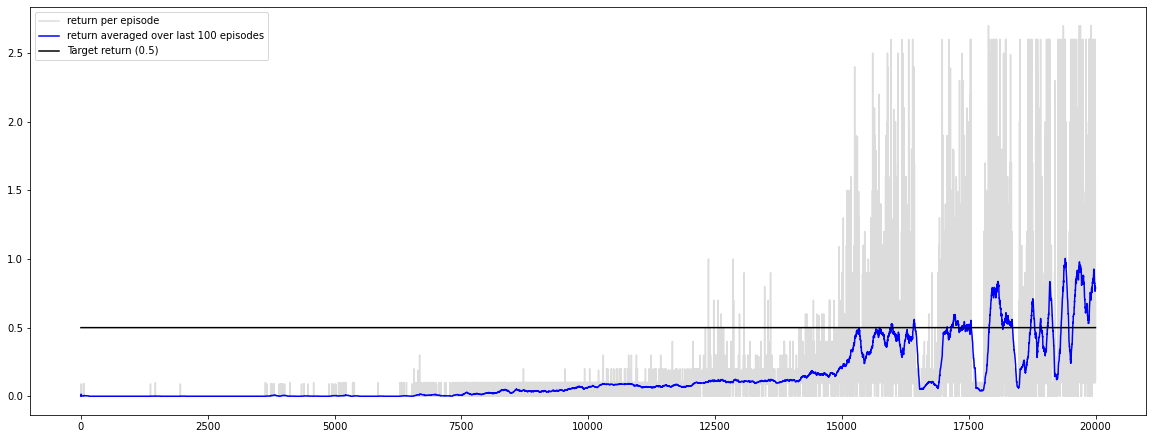

In [6]:
# Plot the results:
plt.figure(figsize=(20,7.5))
plt.plot(episode_returns, color='gainsboro', label='return per episode')
plt.plot(smooth(episode_returns), color='blue', label='return averaged over last 100 episodes')
plt.plot(np.ones(NUM_EPISODES)*0.5, color='black', label='Target return (0.5)')
plt.legend()

# Print the return over the last 100 episodes:
print(f'Over the last 100 episodes, the agent received an average return of {smooth(episode_returns)[-1]}')

In [7]:
# Save weights
first_agent.save(FIRST_ACTOR_WEIGHTS_PATH, FIRST_CRITIC_WEIGHTS_PATH)
second_agent.save(SECOND_ACTOR_WEIGHTS_PATH, SECOND_CRITIC_WEIGHTS_PATH)

## Evaluate

In [8]:
# Dectivate agents' train mode (setting exploration to zero)
first_agent.train_mode = False
second_agent.train_mode = False
# Play 100 episodes and print the average reward (repeated for 10 runs):
for i in tqdm(range(1)):
    cache = np.zeros(100)
    for j in range(100):
        cache[j] = play_one(first_agent, second_agent, env, brain_name)
    print(f'In run {i+1} the Agent received an average return of {np.mean(cache)} over 100 episodes.')

In run 1 the Agent received an average return of 0.38110000574961306 over 100 episodes.



## Watch

In [9]:
# Watch Time
play_one(first_agent, second_agent, env, brain_name, train_mode=False)

0.10000000149011612

## Clean up

In [10]:
# Shutdown
# env.close()